# Flow-based network analysis of effective connectivity

**Created by: _Matthieu Gilson & Gorka Zamora-López_**

The Human Brain Project SGA0 - SGA2 (SP4); SGA3 (WP1)  /  Pompeu Fabra University, Barcelona.

<img src="Logo_HBP_small.png" style="float:left; width:254px; heigth:50px " alt="HBP logo" />
<img src="Logo_UPF_small.png" style="float:right; width:149px; height:50px"  alt="UPF logo" />


<br/>

-----------------
The purpose of this notebook is to showcase, test and validate the integration of effective connectivity tools in EBRAINS and for use in broader workflows. This notebook should:

- Retrieve and load the results of whole-brain EC, estimated previously along the workflow.
- Perform basic flow-based network analysis using the _NetDynFlow_ Python package (_NetDynFlow_ should be available in the Python environment of the EBRAINS Lab, instead of having to perform a local install via '_pip_').
- Save / export the results and use EBRAINS visualization tools to create fancier outputs, e.g. a brain visualiser.

-----------------

Here, we will load whole-brain effective previously estimated (see for example the notebook '1_Mou-EC_estimation.ipynb'. We will then perform some basic and illustrative flow-based network analysis showing how effective connectivity captures a reorganization of the pathways of whole-brain activity propagation during a task, as compared to the resting condition.


#### References and documentation

1. M. Gilson, N. Kouvaris, G. Deco and G. Zamora-López (2018) "Framework based on communicability and flow to analyze complex networks" Phys. Rev. E 97, 052301.
DOI: https://doi.org/10.1103/PhysRevE.97.052301
2. M. Gilson, N. Kouvaris, G. Deco et al. (2019) "Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability" NeuroImage 201, 116007.
DOI: https://doi.org/10.1016/j.neuroimage.2019.116007
3. Gilson M, Zamora-López G, Pallarés V, et al. (2020) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", Network Neurosci. 4(2) 338-373.
DOI: https://doi.org/10.1162/netn_a_00117


#### Software
This Notebook employs the python package _NetDnyFlow_ for performing flow-based network analysis. classification via machine-learning methods
GitHub: https://github.com/mb-BCA/NetDynFlow


#### Data
We employ structural connectivity and resting-state fMRI from published data. It consists of recordings for a cohort of 22 healthy participants udergoing five fMRI sessions each: two sessions in resting-state (R1, R2) and three sessions while watching three distinct segments of a movie (M1, M2, M3).

1. J. Hlinka, M. Palus, M. Vejmelka, et al. (2011) "Functional connectivity in resting-state fMRI: is linear correlation sufficient?" NeuroImage 54, 2218–2225.
DOI: https://doi.org/10.1016/j.neuroimage.2010.08.042
2. D. Mantini, U. Hasson, V. Betti, et al. (2012) "Interspecies activity correlations reveal functional correspondence between monkey and human brain areas." Nat. Methods 9, 277–282.
DOI: https://doi.org/10.1038/nmeth.1868
3. M Gilson, G. Deco, K. Friston et al. (2018) "Effective connectivity inferred from fMRI transition dynamics during movie viewing points to a balanced reconfiguration of cortical interactions." NeuroImage 180, 534-546.
DOI: https://doi.org/10.1016/j.neuroimage.2017.09.061



_**TO-DO**: Reproduce this notebook using a dataset accessible via EBRAINS. This "movie" dataset is not part of the EBRAINS catalog. At least not yet. See file "0\_README.md" for suggestions._



---------
### TO-DO list towards full EBRAINS integration 
Missing technical points, for full integration of the workflows in this notebook.

- Input data is the result of whole-brain EC estimation, which can simply be stored in Drive and loaded here. But… any fancier interface shall be built?
- Incorporate '_NetDynFlow_' to the Python packages available in EBRAINS by default.
- Interface to visualization services. Visualise results in a "standard brain map".


----------
### Import the dependencies

In [1]:
# Import 3rd party packages
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
## TO-DO: pyMOU shall be available in EBRAINS, by default

## Check whether NetDynFlow is installed, otherwise install using pip
try:
    import netdynflow
except:
    ! pip install git+https://github.com/mb-BCA/NetDynFlow.git@master

# Import NetDynFlow
import netdynflow as ndf

### Load and prepare the data

The data required in this notebook is the output of the MOU-EC estimation method previously calculated and saved in, for example, a notebook like '1_MOU-EC_Estimation.ipynb'

So far, we will load datafiles stored in the local Drive of this collab: _'.../Effective Connectivity estimation/Datasets/Movie/'_ . The required data files are:

- 'ECdata_Movie.npz': zipped file containing various results from the MOU-EC estimation.
- 'ROI_Labels.npy': the names of the ROIs in the parcellation.

We load the previously estimated effective connectivity matrices and the rest of the parameters from the MOU-EC optimization: the estimated time-constant $\tau$ and the input covariance $\Sigma$. From these we will generate the flow tensor *DynFlow* encoding the propagation of interacions among the ROIs over time.

In [3]:
%pwd

'/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Jupyter_Notebooks'

In [4]:
## Load the data needed for the fMRI data from the Drive
datapath = '/mnt/user/drive/Shared with groups/Effective Connectivity estimation/Datasets/Movie/'

# Load data previously generated, e.g., in a notebook like '1_MOU-EC_Estimation.ipynb'
ec_data = np.load( datapath + 'ECdata_Movie.npz' )

# Effective connectivity matrices
EC_tmp = ec_data['EC_mod']
# The estimate noise covariances
Sigma = ec_data['Sigma_mod.npy']
# The estimated decay rates (time-constants)
tau_tmp = ec_data['tau_list']
# Load the ROI labels
ROI_labels = np.load(datapath + 'ROI_Labels.npy')

# Identify the number of: subjects, sessions and nodes
n_sub, n_run, N, N = np.shape(EC_tmp)

# Print some feedback
print( 'Number of subjects:', n_sub )
print( 'Number of sessions:', n_run )
print( 'Number of ROIs:', N )

Number of subjects: 22
Number of sessions: 5
Number of ROIs: 66


<br>

### Flow-based network analysis

To perform flow-based network analysis one needs to estimate the temporal evolution of the input-driven interactions between all pairs of ROIs. For each fMRI session this evolution of interactions is encoded on a tensor 'flow' of nT matrix of N x N, where nT is the number of iteration steps. The 'flow' tensor is generated employing the effective connectivity, the input noise-variances and the time-constants previously estimated from the data. Then, the analysis consists of extracting practical information from the 'flow' tensor by aplying a variety of metrics.

In [5]:
## Start generating the flow tensor, for all sessions,
## for all participants

# Set the simulation properties
T = 40.0  # duration
dt = 1.0  # time step
vT = np.arange(0, T+dt*0.5, dt) # discrete simulation steps
nT = vT.size

# Calculate the dynamic flow, for every subject in all five sessions
flow = np.zeros([n_sub,n_run,nT,N,N], np.float) 
for i_sub in range(n_sub):
    for i_run in range(n_run):
        flow[i_sub,i_run,:,:,:] = ndf.DynFlow(EC_tmp[i_sub,i_run], 
                                              tau_tmp[i_sub,i_run], 
                                              Sigma[i_sub,i_run,:,:], 
                                              tmax=T, 
                                              timestep=dt)


#### Global flow analysis

First, we evaluate the total flow, which is the sum of flow interactions between all pairs of ROIs. This quantifies the total activity propagation in the network over time, as a proxy for global communication induced by a perturbation whose amplitude at each node is described by $\Sigma$. 


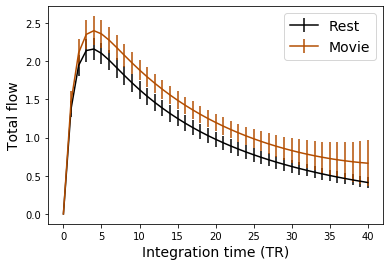

In [6]:
# Calculate total communicability, for each subject in all the five sessions
tot_tmp = np.zeros([n_sub,n_run,nT])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        tot_tmp[i_sub,i_run,:] = ndf.TotalEvolution(flow[i_sub,i_run,:,:,:])

# Plot the results sorted in resting-state and movie watching conditions
plt.figure()
plt.errorbar(vT, tot_tmp[:,:2,:].mean(axis=(0,1)), 
             yerr=tot_tmp[:,:2,:].std(axis=(0,1)) / np.sqrt(n_sub), 
             color='k')
plt.errorbar(vT, tot_tmp[:,2:,:].mean(axis=(0,1)), 
             yerr=tot_tmp[:,2:,:].std(axis=(0,1)) / np.sqrt(n_sub), 
             color=[0.7,0.3,0])
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('Total flow', fontsize=14)
plt.legend(['Rest','Movie'], fontsize=14)
    
plt.show()

In this plot each curve corresponds to the average over all subjects and the bars indicate the standard error of the mean over the subjects. The results show a higher level of interactions in the network in the movie watching condition than in rest.


#### ROI-based analysis of flow

Now we turn to the more refined scale of ROIs to examine the flow. We also reorganize the list of ROIs to group them by anatomical regions.

In [7]:
# Organize the ROIs into groups
# occipital ROIs
# CUN, PCAL, LING, LOCC, FUS
ind_occ = [3, 20, 12, 10, 6] 
# temporal ROIs
# IT, MT, ST, TT, TP
ind_tmp = [8, 14, 29, 32, 31]
# parietal ROIs
# IP, SP, SMAR, BSTS, PCUN
ind_par = [7, 28, 30, 0, 24]
# central ROIs
# PARC, PREC, PSTC
ind_cnt = [15, 23, 21]
# frontal ROIs:
# FP, SF, RMF, CMF, LOF, MOF, POPE, PORB, PTRI
ind_frnt = [5, 27, 26, 2, 11, 13, 17, 18, 19]
# cingulate ROIs
# ENT, PARH, RAC, CAC, PC, ISTC
ind_cing = [4, 16, 25, 1, 22, 9]

# rearranged list of ROIs for right hemisphere
ind_aff = np.array(ind_occ + ind_tmp + ind_par + ind_cnt + ind_frnt + ind_cing, 
                   dtype=np.int)

# get labels for homotopic regions
ROI_labels_sym = np.array(ROI_labels[:int(N/2)], dtype=np.str)
for i in range(int(N/2)):
    # remove white space
    ROI_labels_sym[i] = ROI_labels_sym[i].replace(' ', '')
    # remove first letter (left or right)
    ROI_labels_sym[i] = ROI_labels_sym[i].replace('r', '')

ROI_labels_sym = ROI_labels_sym[ind_aff]

print( 'Done.' )

Done.


In [8]:
# Calculate the input and output flows for all ROIs, in each subject for all 5 sessions
in_flow = np.zeros([n_sub,n_run,nT,N])
out_flow = np.zeros([n_sub,n_run,nT,N])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        in_flow[i_sub,i_run,:,:], out_flow[i_sub,i_run,:,:] = \
                                        ndf.NodeEvolution(flow[i_sub,i_run,:,:,:])

print( 'Done.' )

Done.


For illustration, we plot the input and output flows for the 'rest' condition. The interpretation is as follows:

- strong input flow means that the ROI listens to the rest of the network (its activity is strongly affected by that of others);
- strong output flow means that the ROI broadcasts to the rest of the network (its activity strongly affects that of others).

The third plot can be used to classify ROI in listeners or broadcasters (or both).

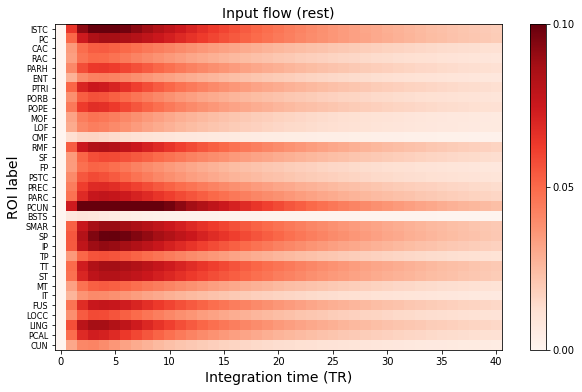

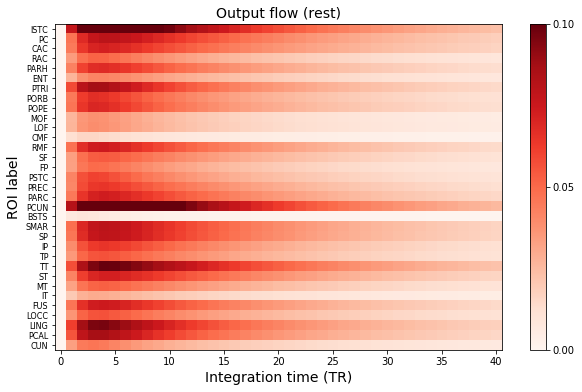

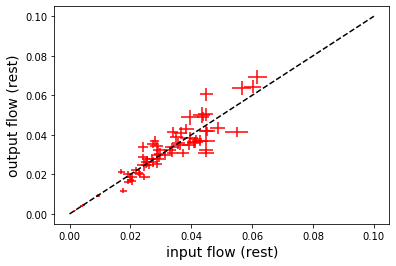

In [10]:
# Rest averaged over subjects and sessions
rest_in_flow  = in_flow[:,:2,:,:].mean(axis=(0,1))
rest_out_flow = out_flow[:,:2,:,:].mean(axis=(0,1))

# Group homotopic ROIs
sym_rest_in_flow  = rest_in_flow[:,:N//2]  + rest_in_flow[:,N//2:][:,::-1]
sym_rest_out_flow = rest_out_flow[:,:N//2] + rest_out_flow[:,N//2:][:,::-1]

# Plot the input flows
plt.figure(figsize=(10,6))
plt.imshow(sym_rest_in_flow[:,ind_aff].T, origin='lower', cmap='Reds', aspect='auto')
plt.clim(0, 0.1)
plt.colorbar(ticks=[0,0.05,0.1])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Input flow (rest)', fontsize=14)

# Plot the output flows
plt.figure(figsize=(10,6))
plt.imshow(sym_rest_out_flow[:,ind_aff].T, origin='lower', cmap='Reds', aspect='auto')
plt.clim(0, 0.1)
plt.colorbar(ticks=[0,0.05,0.1])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Output flow (rest)', fontsize=14)

# Plot the comparison of input / output flows per ROI
plt.figure()
plt.errorbar(in_flow[:,:2,5,:].mean(axis=(0,1)), 
             out_flow[:,:2,5,:].mean(axis=(0,1)), 
             xerr = in_flow[:,:2,5,:].std(axis=(0,1)) / np.sqrt(2*n_sub), 
             yerr = out_flow[:,:2,5,:].std(axis=(0,1)) / np.sqrt(2*n_sub), 
             color='r', 
             linestyle='')
plt.plot([0,0.1], [0,0.1], '--k')
plt.xlabel('input flow (rest)', fontsize=14)
plt.ylabel('output flow (rest)', fontsize=14)

plt.show()

<br>

Then, we plot **the difference** between the flows in the two conditions (averaged over subjects), to see which ROIs change their listening/broadcasting roles from during the movie watching condition as compared to rest. 


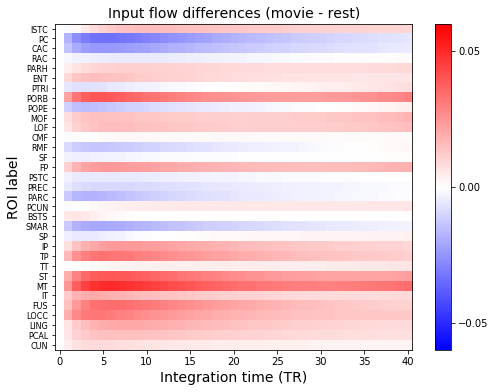

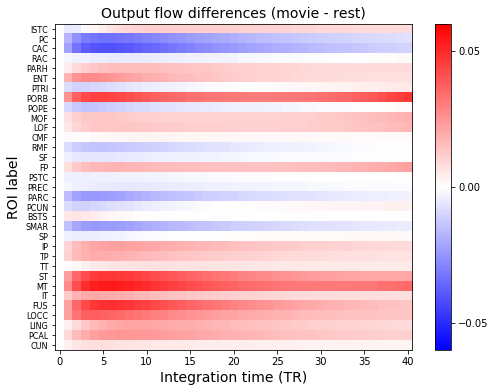

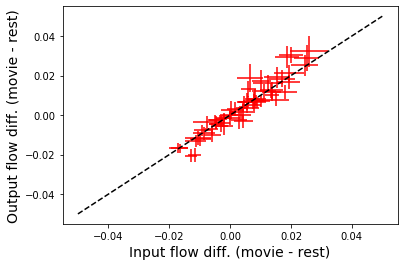

In [11]:
## First, we need to get the averaged in-/output flows 
## for the movie watching condition
# Movie averaged over subjects and sessions
movie_in_flow = in_flow[:,2:,:,:].mean(axis=(0,1))
movie_out_flow = out_flow[:,2:,:,:].mean(axis=(0,1))

# Group homotopic ROIs
sym_movie_in_flow  = movie_in_flow[:,:N//2]  + movie_in_flow[:,N//2:][:,::-1]
sym_movie_out_flow = movie_out_flow[:,:N//2] + movie_out_flow[:,N//2:][:,::-1]


## Calculate the differences (movie minus rest) averaged over subjects and sessions
diff_in_flow  = in_flow[:,2:,:,:].mean(axis=(0,1))  - \
                in_flow[:,:2,:,:].mean(axis=(0,1))
diff_out_flow = out_flow[:,2:,:,:].mean(axis=(0,1)) - \
                out_flow[:,:2,:,:].mean(axis=(0,1))

# Group homotopic ROIs
sym_diff_in_flow  = diff_in_flow[:,:int(N/2)]  + \
                    diff_in_flow[:,int(N/2):][:,::-1]
sym_diff_out_flow = diff_out_flow[:,:int(N/2)] + \
                    diff_out_flow[:,int(N/2):][:,::-1]


## And plot the results
# Plot the differences in input flows
plt.figure(figsize=(8,6))
plt.imshow(sym_diff_in_flow[:,ind_aff].T,  origin='lower', 
                                           cmap='bwr', 
                                           aspect='auto')
plt.clim(-0.06, 0.06)
plt.colorbar(ticks=[-0.05,0,0.05])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Input flow differences (movie - rest)', fontsize=14)

# Plot the differences in output flows
plt.figure(figsize=(8,6))
plt.imshow(sym_diff_out_flow[:,ind_aff].T, origin='lower', 
                                           cmap='bwr', 
                                           aspect='auto')
plt.clim(-0.06, 0.06)
plt.colorbar(ticks=[-0.05,0,0.05])
plt.yticks(range(int(N/2)), ROI_labels_sym, fontsize=8)
plt.xlabel('Integration time (TR)', fontsize=14)
plt.ylabel('ROI label', fontsize=14)
plt.title('Output flow differences (movie - rest)', fontsize=14)

# Plot the comparison of input / output relations
plt.figure()
diff_in_flow_tmp  = in_flow[:,2:,5,:].mean(axis=(1))  - \
                    in_flow[:,:2,5,:].mean(axis=(1))
diff_out_flow_tmp = out_flow[:,2:,5,:].mean(axis=(1)) - \
                    out_flow[:,:2,5,:].mean(axis=(1))
plt.errorbar(diff_in_flow_tmp.mean(0), 
             diff_out_flow_tmp.mean(0),
             xerr = diff_in_flow_tmp.std(0) / np.sqrt(n_sub), 
             yerr = diff_out_flow_tmp.std(0) / np.sqrt(n_sub), 
             color='r', 
             linestyle='')
plt.plot([-0.05,0.05], [-0.05,0.05], '--k')
plt.xlabel('Input flow diff. (movie - rest)', fontsize=14)
plt.ylabel('Output flow diff. (movie - rest)', fontsize=14)

plt.show()

The third plot shows that the main changes in movie compared to rest are ROIs increasing their broadcasting roles.

<br>

#### Flow-based communities
Last, we show that building on top of effective connectivity, flow-based analysis reveals the mesoscopic organization of the flows in the whole-brain dynamics in tasks. That can be achieved by exploring the formation of flow-clusters and their temporal evolution, from segregated to integrated assemblies.

The following function implements the **greedy algorithm** used by Newman, which we will employ here to iteratively aggregate ROIs according to their flow interactions. The algorithm is initialized with singletons, i.e., each ROI being assigned to a group of 1 element. When Q cannot be increased, the algorithm stops.


In [12]:
# Community detection function (Newman's greedy aggregation)
def calc_part(inter_mat):
   # initial partition with all nodes disconnected (each in a singleton)
    part_tmp = []
    for i in range(N):
        part_tmp += [[i]]
    stop = False
    while not stop:
        # lenght of current partition (number of groups)
        n = len(part_tmp)
        # matrix of Q update when merging a pair of groups
        delta_Q = np.zeros([n,n])
        # Check change in Q for all possible merging of 2 groups
        for ii in range(n):
            for jj in range(n):
                if ii != jj:
                    for i in part_tmp[ii]:
                        for j in part_tmp[jj]:
                            # sum of interactions between 2 groups
                            delta_Q[ii,jj] += inter_mat[i,j] + inter_mat[j,i]
                else:
                    # only calculate for distinct groups, here set to a large negative value
                    delta_Q[ii,jj] = -1e50
        # Check if Q can be increased; if not, stop
        if delta_Q.max() > 0:
            # Get indices of groups for maximum change of Q
            ii_max = int(np.argmax(delta_Q) / n)
            jj_max = np.argmax(delta_Q) - ii_max*n
            # Create new partition with merging of ii_max and jj_max
            new_part_tmp = []
            for ii in range(n):
                if ii != ii_max and ii != jj_max:
                    new_part_tmp += [part_tmp[ii]]
                elif ii == ii_max:
                    new_part_tmp += [part_tmp[ii_max] + part_tmp[jj_max]]
            part_tmp = new_part_tmp
        else:
            stop = True

    # Return the partition as a list of integer lists
    return part_tmp



Now we will use the function to detect communities for each subject at 3 integration times: early (t = 1 TR), when the network effect is strong (t = 5 TR) and late (t = 20 TR)

In [17]:
## Flow-based community detection
# WARNING: Running this cell will take a few minutes

# Load the Jaccobian matrix from the EC data
J_mod = ec_data['J_mod']

# Create binary masks, helpers
mask_diag = np.eye(N, dtype=np.bool)
mask_offdiag = np.logical_not(mask_diag)

# Get a diagonal matrix from the Jacobian
J0 = np.array(J_mod)
J0[:,:,mask_offdiag] = 0

# Integration times for community detection
vT = np.array([1,5,20], dtype=np.int)
nT = vT.size

# Newman-style expected C with directed conn
C_null = np.zeros(J_mod.shape)
for i_sub in range(n_sub):      # in * out / total
    for i_run in range(n_run):  # in * out / total
        C = np.copy(J_mod[i_sub,i_run,:,:])
        C[mask_diag] = 0
        C_null[i_sub,i_run,:,:] = np.outer(C.sum(1), C.sum(0))
        C_null[i_sub,i_run,mask_diag] = 0
        C_null[i_sub,i_run,:,:] *= C.sum() / C_null[i_sub,i_run,:,:].sum()

# Community analysis from similarity of communicability
summary_community = np.zeros([n_sub, n_run, nT,N,N], np.float)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        print('sub / run', i_sub, i_run)
        renorm_factor = -np.sum( 1.0 / J0[i_sub,i_run,:,:].diagonal() )
        for iT in range(nT):
            # Difference between communicability and null version
            flow_diff_null_tmp =  \
                ( spl.expm(J_mod[i_sub,i_run,:,:] * vT[iT])  - 
                  spl.expm((J0[i_sub,i_run,:,:] + C_null[i_sub,i_run,:,:]) * vT[iT]) 
                ) / renorm_factor
            flow_diff_null_tmp =  \
                np.dot( np.sqrt(Sigma[i_sub,i_run,:,:]), flow_diff_null_tmp )

            # Calculate communities
            part_tmp = calc_part(flow_diff_null_tmp)
            # Print number of groups
            print('t =', vT[iT], ':', len(part_tmp))

            # Matrices of coparticipation values: add 1 if the 2 groups are in the same 
            # community for each subject/session
            for ip in range(len(part_tmp)):
                for i in part_tmp[ip]:
                    for j in part_tmp[ip]:
                        if i_run < 2:
                            summary_community[i_sub,0,iT,i,j] += 1
                        else:
                            summary_community[i_sub,1,iT,i,j] += 1

summary_community[:,0,:,:,:] /= 2.
summary_community[:,1,:,:,:] /= 3.

print( '\nFinished.' )

sub / run 0 0
t = 1 : 8
t = 5 : 8
t = 20 : 13
sub / run 0 1
t = 1 : 8
t = 5 : 6
t = 20 : 10
sub / run 0 2
t = 1 : 8
t = 5 : 6
t = 20 : 13
sub / run 0 3
t = 1 : 8
t = 5 : 7
t = 20 : 13
sub / run 0 4
t = 1 : 8
t = 5 : 8
t = 20 : 9
sub / run 1 0
t = 1 : 6
t = 5 : 6
t = 20 : 9
sub / run 1 1
t = 1 : 7
t = 5 : 7
t = 20 : 8
sub / run 1 2
t = 1 : 5
t = 5 : 6
t = 20 : 6
sub / run 1 3
t = 1 : 7
t = 5 : 6
t = 20 : 9
sub / run 1 4
t = 1 : 7
t = 5 : 5
t = 20 : 11
sub / run 2 0
t = 1 : 7
t = 5 : 6
t = 20 : 9
sub / run 2 1
t = 1 : 6
t = 5 : 6
t = 20 : 8
sub / run 2 2
t = 1 : 6
t = 5 : 6
t = 20 : 9
sub / run 2 3
t = 1 : 8
t = 5 : 7
t = 20 : 8
sub / run 2 4
t = 1 : 7
t = 5 : 7
t = 20 : 10
sub / run 3 0
t = 1 : 6
t = 5 : 5
t = 20 : 7
sub / run 3 1
t = 1 : 7
t = 5 : 6
t = 20 : 8
sub / run 3 2
t = 1 : 7
t = 5 : 7
t = 20 : 8
sub / run 3 3
t = 1 : 6
t = 5 : 6
t = 20 : 11
sub / run 3 4
t = 1 : 7
t = 5 : 5
t = 20 : 14
sub / run 4 0
t = 1 : 6
t = 5 : 5
t = 20 : 9
sub / run 4 1
t = 1 : 7
t = 5 : 6
t = 20 : 10
s

Now we **reorder the ROIs**, grouping them according to the community structure at rest, averaged over all subjects.

In [18]:
# Reorder ROIs according to rest community for early integration time 
# (assess stable communities over all rest sessions)
stab_community_rest = summary_community[:,:2,0,:,:].mean(axis=(0,1))
stab_community_rest[mask_diag] = 0
stab_community_rest_null = np.outer( stab_community_rest.sum(1), 
                                     stab_community_rest.sum(0) )
stab_community_rest_null[mask_diag] = 0
stab_community_rest_null *= stab_community_rest.sum() / stab_community_rest_null.sum()

part_rest = calc_part(stab_community_rest - stab_community_rest_null)

print('Number of groups:', len(part_rest))
for ii in range(len(part_rest)):
    print( 'Group', ii, 'with', len(part_rest[ii]), 'ROIs' )
    print( ROI_labels[part_rest[ii]] )
    print()

# Reorganize ROIs according to partition
part_ind = np.array(part_rest[0] + part_rest[2] + part_rest[1] + part_rest[3], 
                    dtype=np.int)

Number of groups: 4
Group 0 with 18 ROIs
[' rCAC' ' lCAC' '  rMT' 'rPARC' 'lPARC' '  lST' '  rTT' '  lTT' '  rST'
 '  lMT' 'rSMAR' 'lSMAR' '  rTP' '  lTP' ' rRMF' '  rSF' '  lSF' ' lRMF']

Group 1 with 16 ROIs
[' rCMF' ' rCUN' ' lCUN' 'lPSTC' 'rPSTC' 'lPREC' 'rPREC' 'rBSTS' 'lBSTS'
 '  rPC' '  lPC' ' lRAC' ' rRAC' 'lPCUN' 'rPCUN' ' lCMF']

Group 2 with 20 ROIs
[' rENT' ' rFUS' 'rLOCC' 'rLING' 'rPCAL' 'lPCAL' 'lLING' 'lLOCC' ' lFUS'
 'lPARH' 'rPARH' '  lIT' '  rIT' 'rISTC' 'lISTC' '  lIP' '  rIP' '  rSP'
 '  lSP' ' lENT']

Group 3 with 12 ROIs
['  rFP' '  lFP' 'lPORB' ' lLOF' ' rLOF' 'rPORB' 'lPOPE' 'lPTRI' 'rPOPE'
 'rPTRI' ' lMOF' ' rMOF']



Plot the matrices of coparticipation values. The coparticipation values are close to 1 if the two ROIs are in the same community for all subjects of a condition (rest or movie). Otherwise, it is close to 0.

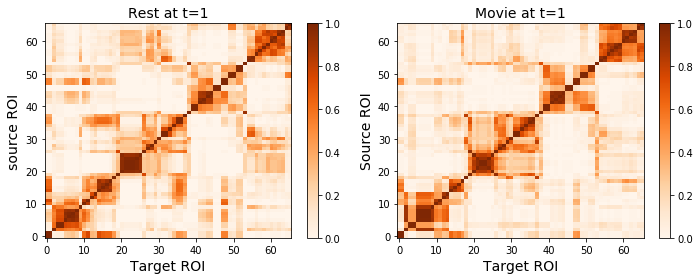

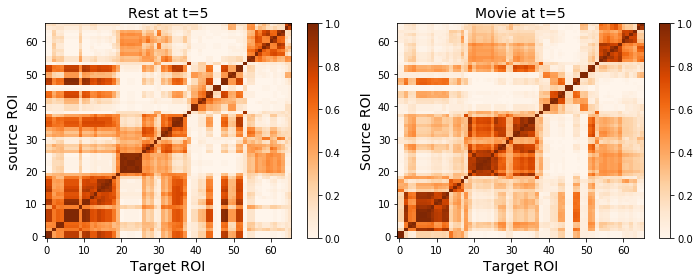

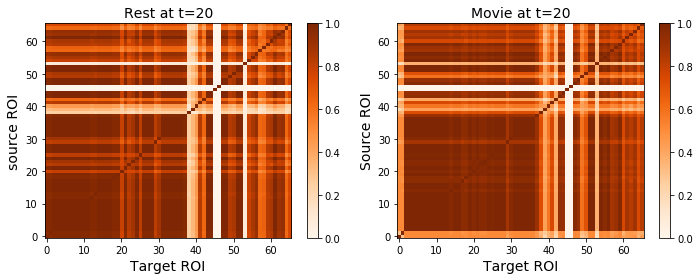

In [24]:
# Matrix plots of flow communities with reordered indices
for iT in range(nT):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(summary_community[:,0,iT,:,:].mean(0)[part_ind,:][:,part_ind], 
               origin='lower', 
               cmap='Oranges',
               aspect='auto')
    plt.clim(0,1)
    plt.xlabel('Target ROI', fontsize=14)
    plt.ylabel('source ROI', fontsize=14)
    plt.colorbar()
    plt.title('Rest at t=' + str(vT[iT]), fontsize=14)

    plt.subplot(1,2,2)
    plt.imshow(summary_community[:,1,iT,:,:].mean(0)[part_ind,:][:,part_ind], 
               origin='lower', 
               cmap='Oranges',
               aspect='auto')
    plt.clim(0,1)
    plt.xlabel('Target ROI', fontsize=14)
    plt.ylabel('Source ROI', fontsize=14)
    plt.colorbar()
    plt.title('Movie at t=' + str(vT[iT]), fontsize=14)
    
    plt.tight_layout()
    
plt.show()


Check for significant changes in community coparticipation values between rest and movie.

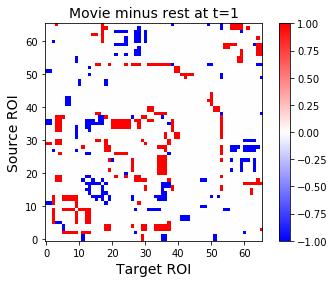

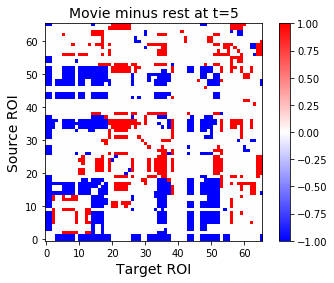

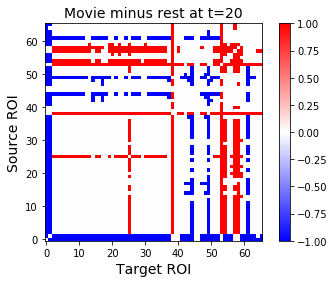

In [21]:
sig_diff_flow = np.zeros([nT,N,N])
for iT in range(nT):
    for i in range(N):
        for j in range(N):
            if not np.array_equiv( summary_community[:,0,iT,i,j], 
                                   summary_community[:,1,iT,i,j] ) \
                and stt.mannwhitneyu( summary_community[:,0,iT,i,j], 
                                      summary_community[:,1,iT,i,j] )[1] < 0.01:
                sig_diff_flow[iT,i,j] = \
                            np.sign( summary_community[:,1,iT,i,j].mean() - 
                                     summary_community[:,0,iT,i,j].mean() )
                
# Matrix plots of statistical differences between coparticipation values
for iT in range(nT):
    plt.figure()
    plt.imshow(sig_diff_flow[iT,part_ind,:][:,part_ind], origin='lower', cmap='bwr')
    plt.clim(-1,1)
    plt.xlabel('Target ROI', fontsize=14)
    plt.ylabel('Source ROI', fontsize=14)
    plt.colorbar()
    plt.title('Movie minus rest at t=' + str(vT[iT]), fontsize=14)
    
plt.show()